# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Capstone Project Model Solution
In this notebook, we provide a model solution to the capstone project on machine learning for options trading. You can refer to this if you are stuck in any step while building your solution. The model solution guides you to answer the problem statements posed in the capstone project. 

The notebook is structured as follows:
1. [Import the Data](#read)
2. [Features Related to the Underlying Asset](#features_underlying)
3. [Features Related to the Options Greeks](#greeks)
4. [Features Related to the Options Contract](#contract)
2. [Strategy Calculations](#calculations)
3. [Scale the Data](#scaling)
4. [Logistic Regression](#logistic_regression)
5. [Performance Analysis of the Model](#performance)
## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For technical indicators
import talib

# For warnings suppression
import warnings 
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler

## <a id='read'></a>
## Import the Data

Import the files `spx_eom_options_2010_2022.bz2` as `options_data` and `sp500_index_2010_2022.csv` as `underlying_data` using the `read_pickle` and `read_csv` method of `pandas`.
These CSV files are available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Import EOM SPX options data from 2010-2022
options_data = pd.read_pickle(
    "../data_modules/spx_eom_expiry_options_2010_2022.bz2")

# Set index for the data
options_data.index.name = 'index'

# Import the underlying data i.e. S&P 500 index data
underlying_data = pd.read_csv(
    '../data_modules/sp500_index_2010_2022.csv', index_col='Date')[['Open', 'High', 'Low', 'Close']]

# Convert index dtype to datetime
underlying_data.index = pd.to_datetime(underlying_data.index)

In the `underlying_data`, filter the days for which the options data is available in the dataframe `options_data` and create the `atm_strike_price` column to store the strike price. 

The atm strike price is the strike price of the contract that is closest to the close price of the underlying. So, to find the `atm_strike_price` values, find the strike price of the contract which has the minimum `' [STRIKE_DISTANCE_PCT]'` value.

In [3]:
# Selecting underlying data for index range of options data
underlying_data = underlying_data[underlying_data.index.isin(
    options_data.index)].dropna()

# Create the 'atm_strike_price' column with NaN values
underlying_data['atm_strike_price'] = np.nan

# Calculate atm strike price
for i in range(0, len(underlying_data)):
    trading_day_data = options_data.loc[underlying_data.index[i]]
    underlying_data['atm_strike_price'][i] = trading_day_data[trading_day_data[' [STRIKE_DISTANCE_PCT]']
                                                              == trading_day_data[' [STRIKE_DISTANCE_PCT]'].min()][' [STRIKE]'][0]

The `underlying_data` dataframe has OHLC values of the S&P 500 index along with the atm strike price. The `options_data` dataframe has option chain data of call and put options of the S&P 500 index. Merge these two dataframes and create a master data frame that has the trading day as an index and OHLC values of the underlying, atm strike price and option chain data of call and put options of the S&P 500 index. This dataframe is named `underlying_data`.

In [4]:
# Change the data type of the column ' [QUOTE_DATE]' from 'object' to 'datetime'
options_data[' [QUOTE_DATE]'] = pd.to_datetime(options_data.index)

# Merge the dataframes 'underlying_data' and 'options_data'
underlying_data = pd.merge(underlying_data, options_data, left_on=[
                           'Date', 'atm_strike_price'], right_on=[' [QUOTE_DATE]', ' [STRIKE]'])

# Improving the column names by changing them to lower case and adding 'call' and 'put' to the names of the columns
underlying_data.columns = underlying_data.columns.str.replace('[', '').str.replace(
    ']', '').str.strip().str.lower().str.replace('c_', 'call_').str.replace('p_', 'put_')

# Removing rows where either the call and put strike prices are 0
underlying_data = underlying_data[(
    underlying_data.call_last != 0) & (underlying_data.put_last != 0)]
underlying_data.head()

,open,high,low,close,atm_strike_price,strike,strike_distance_pct,call_last,underlying_last,put_last,...,call_theta,call_rho,call_iv,put_delta,put_gamma,put_vega,put_theta,put_rho,put_iv,quote_date
1,1117.010010,1123.459961,1116.510010,1118.310059,1125.0,1125.0,0.006,16.15,1117.98,23.2,...,-0.30847,0.37731,0.156100,-0.55790,0.00780,1.26269,-0.36309,-0.53265,0.156850,2010-03-02
2,1119.359985,1125.640015,1116.579956,1118.790039,1125.0,1125.0,0.006,19.50,1118.49,23.2,...,-0.32176,0.37714,0.152320,-0.54783,0.00797,1.24798,-0.35476,-0.50447,0.157850,2010-03-03
3,1119.119995,1123.729980,1116.660034,1122.969971,1125.0,1125.0,0.002,19.50,1122.68,22.0,...,-0.33080,0.38313,0.158060,-0.52029,0.00810,1.23698,-0.37690,-0.46392,0.158500,2010-03-04
7,1140.219971,1148.260010,1140.089966,1145.609985,1150.0,1150.0,0.004,13.10,1145.36,20.0,...,-0.37266,0.29926,0.149510,-0.54093,0.00929,1.11512,-0.40092,-0.38429,0.151130,2010-03-10
8,1143.959961,1150.239990,1138.989990,1150.239990,1150.0,1150.0,0.000,13.30,1149.96,17.4,...,-0.38001,0.32599,0.143280,-0.49280,0.00942,1.09985,-0.41159,-0.32547,0.155080,2010-03-11


The input features for the ML model to predict the options strategy to deploy has two types of features. 
1. Features related to the underlying asset.
2. Features related to the options market.

<a id='features_underlying'></a>
## Features Related to the Underlying Asset

Historical returns of the underlying asset across multiple periods, technical indicators of momentum and volatility are used as input features.

1. **Historical returns:** 1,5,10,22,44 and 88 days returns of the underlying asset.
2. **Momentum:** Relative Strength Index (RSI) of the close price of the underlying asset.
3. **Volatility:** Average True Range(ATR), upper, lower and middle Bollinger Bands of the underlying asset.


In [5]:
# Historical returns
intervals = [1, 5, 10, 22, 44, 88]

# Past returns of multiple time periods
for t in intervals:
    underlying_data[f'f_ret_{t}'] = underlying_data.close.pct_change(t)

# RSI of the underlying
underlying_data['f_rsi'] = talib.RSI(underlying_data.close)

# ATR of the underlying
underlying_data['f_natr'] = talib.NATR(
    underlying_data.high, underlying_data.low, underlying_data.close)

# Bollinger bands of the underlying
upper, middle, lower = talib.BBANDS(underlying_data.close)
underlying_data['f_norm_upper'] = upper/underlying_data.close
underlying_data['f_norm_lower'] = lower/underlying_data.close
underlying_data['f_norm_middle'] = middle/underlying_data.close

# Features related to the underlying asset
underlying_data.filter(like='f_').dropna().head()

,f_ret_1,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_rsi,f_natr,f_norm_upper,f_norm_lower,f_norm_middle
97,-0.006049,-0.010488,0.029061,0.045139,0.168393,0.159240,62.728368,1.205084,1.026167,0.991010,1.008588
98,-0.011200,-0.030223,0.019072,0.033383,0.142588,0.145765,56.679002,1.328214,1.033313,0.994247,1.013780
99,-0.019495,-0.047833,-0.000604,0.012315,0.121113,0.119246,48.084267,1.444380,1.050383,0.997396,1.023889
100,0.013398,-0.016516,-0.026535,0.031160,0.132125,0.111827,53.230963,1.446851,1.033278,0.980709,1.006994
101,0.004310,-0.019221,-0.038889,0.029239,0.137419,0.112124,54.804020,1.422389,1.018753,0.978751,0.998752


<a id='greeks'></a>
## Features Related to the Options Greeks

Features related to options greeks such as delta, gamma, vega, theta, and rho are used to measure different factors that might affect the price of an options contract. These features are already present in the dataframe `underlying_data`.

In [6]:
# Features related to options greeks
underlying_data[['call_delta', 'call_gamma', 'call_vega', 'call_theta', 'call_rho',
                 'put_delta', 'put_gamma', 'put_vega', 'put_theta', 'put_rho', ]].head()

,call_delta,call_gamma,call_vega,call_theta,call_rho,put_delta,put_gamma,put_vega,put_theta,put_rho
1,0.44153,0.00792,1.26223,-0.30847,0.37731,-0.55790,0.00780,1.26269,-0.36309,-0.53265
2,0.44955,0.00824,1.24661,-0.32176,0.37714,-0.54783,0.00797,1.24798,-0.35476,-0.50447
3,0.47999,0.00819,1.23668,-0.33080,0.38313,-0.52029,0.00810,1.23698,-0.37690,-0.46392
7,0.45857,0.00943,1.11520,-0.37266,0.29926,-0.54093,0.00929,1.11512,-0.40092,-0.38429
8,0.50640,0.01009,1.10025,-0.38001,0.32599,-0.49280,0.00942,1.09985,-0.41159,-0.32547


 <a id='contract'></a>
## Features Related to the Options Contract
In addition to the options greeks, other metrics of options contracts such as days to expiration, last traded price of the at the money call and put, implied volatility of the at the money call and put, last traded price of the underlying asset and strike price of at the money contract are used as input features.



In [7]:
# Print the features related to the options contract
underlying_data[['dte', 'call_last', 'put_last',
                 'close', 'call_iv', 'put_iv',  'atm_strike_price']].head()

,dte,call_last,put_last,close,call_iv,put_iv,atm_strike_price
1,28.96,16.15,23.2,1118.310059,0.156100,0.156850,1125.0
2,27.96,19.50,23.2,1118.790039,0.152320,0.157850,1125.0
3,26.96,19.50,22.0,1122.969971,0.158060,0.158500,1125.0
7,20.96,13.10,20.0,1145.609985,0.149510,0.151130,1150.0
8,19.96,13.30,17.4,1150.239990,0.143280,0.155080,1150.0


Create a final features list combining all three types of features and store it in the list features.

In [8]:
# Final list of features
features = ['call_last', 'put_last', 'close', 'atm_strike_price',
            'dte', 'call_delta', 'call_gamma', 'call_vega',
            'call_theta', 'call_rho', 'call_iv', 'put_delta', 'put_gamma',
            'put_vega', 'put_theta', 'put_rho', 'put_iv', 'f_ret_1', 'f_ret_5',
            'f_ret_10', 'f_ret_22', 'f_ret_44', 'f_ret_88', 'f_natr', 'f_rsi',
            'f_norm_upper', 'f_norm_lower', 'f_norm_middle']

# Values of input features
underlying_data[features].dropna().head()

,call_last,put_last,close,atm_strike_price,dte,call_delta,call_gamma,call_vega,call_theta,call_rho,...,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle
97,19.10,26.5,1296.390015,1295.0,17.0,0.50888,0.00757,1.14638,-0.56401,0.29972,...,-0.010488,0.029061,0.045139,0.168393,0.159240,1.205084,62.728368,1.026167,0.991010,1.008588
98,25.60,22.3,1281.869995,1280.0,16.0,0.50798,0.00678,1.10044,-0.65746,0.27696,...,-0.030223,0.019072,0.033383,0.142588,0.145765,1.328214,56.679002,1.033313,0.994247,1.013780
99,32.35,25.5,1256.880005,1255.0,15.0,0.52145,0.00581,1.04815,-0.86532,0.27448,...,-0.047833,-0.000604,0.012315,0.121113,0.119246,1.444380,48.084267,1.050383,0.997396,1.023889
100,23.50,24.8,1273.719971,1275.0,14.0,0.49193,0.00664,1.02815,-0.78472,0.23935,...,-0.016516,-0.026535,0.031160,0.132125,0.111827,1.446851,53.230963,1.033278,0.980709,1.006994
101,22.90,21.9,1279.209961,1280.0,13.0,0.49904,0.00768,0.99892,-0.74158,0.23038,...,-0.019221,-0.038889,0.029239,0.137419,0.112124,1.422389,54.804020,1.018753,0.978751,0.998752


<a id='calculations'></a>
## Strategy Calculations

The cost of the straddle is the sum of the put premium and call premium. Create the column `cost_straddle` in the `underlying_data` dataframe. In this exercise, we are testing a short straddle strategy where a straddle is shorted on the trading day and bought back after 3 days.

Create the column `straddle_returns` in the `underlying_data` dataframe. 

The short straddle strategy is profitable when the cost of straddle declines during the holding period of three days. Hence, store 1 as `straddle_returns` when the cost of straddle on trading day is greater than cost of straddle after three days. Similarly, store 0 as `straddle_returns` when the cost of straddle on trading day is less than cost of straddle after three days.

In [9]:
# Create the column 'cost_straddle'
underlying_data['cost_straddle'] = underlying_data['put_last']+underlying_data['call_last']

# Create the column 'straddle_returns'
underlying_data['straddle_returns'] = np.where(
     underlying_data.cost_straddle > underlying_data.cost_straddle.shift(-3), 1, 0)

In [10]:
# Create list 'model_columns' with input features, target variable 
model_columns = ['call_last', 'dte', 'call_delta', 'call_gamma', 'call_vega',
       'call_theta', 'call_rho', 'call_iv', 'put_delta', 'put_gamma',
       'put_vega', 'put_theta', 'put_rho', 'put_iv', 'f_ret_1', 'f_ret_5',
       'f_ret_10', 'f_ret_22', 'f_ret_44', 'f_ret_88', 'f_natr', 'f_rsi',
       'f_norm_upper', 'f_norm_lower', 'f_norm_middle','straddle_returns']

# Create the dataframe 'model_data' by selecting 'model_columns' from 'underlying_data'
model_data = underlying_data[model_columns]
model_data.call_iv = pd.to_numeric(model_data.call_iv, errors='coerce')
model_data.put_iv = pd.to_numeric(model_data.put_iv, errors='coerce')
model_data=model_data.dropna()

Create dependent variable(y) and independent variables(X) from `underlying_data`

In [11]:
# Store the data of input variables in X
X = model_data.drop(['straddle_returns'], axis=1)

# Store the target variable in y
y = model_data['straddle_returns'].shift(-1)

Create train, test datasets with 80% and 20% data respectively

In [12]:
# Use test_size as 20%
test_size = int(0.2*(len(X)))

# Create train and test sets for dependent and independent variables
X_train = X[:-test_size]
X_test = X[-test_size:-1]
y_train = y[:-test_size]
y_test = y[-test_size:-1]
y_test = [int(x) for x in y_test]
# Print 'y_test'
y_test[:5]

[1, 1, 1, 1, 0]

The target variable of '0' indicates that the short straddle is not profitable while '1' indicates that the short straddle is  profitable.

<a id='scaling'></a>
## Scale the Data

Scale the train and test data using `StandardScaler()` method of `sklearn.preprocessing`

In [13]:
# Create the scaler object
scaler = StandardScaler()

# Scale the train data and store in 'X_train_scaled'
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

# Scale the test data and store in 'X_test_scaled'
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Save the scaled independent variables in 'X_scaled'
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
round(X_scaled.head(),2)

,call_last,dte,call_delta,call_gamma,call_vega,call_theta,call_rho,call_iv,put_delta,put_gamma,...,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle
97,-0.26,0.33,0.16,-0.19,-0.81,0.45,-0.51,0.69,0.10,-0.17,...,-0.54,0.71,0.69,2.26,1.42,0.08,0.56,0.59,0.39,0.75
98,0.07,0.21,0.14,-0.21,-0.87,0.35,-0.59,1.06,0.09,-0.18,...,-1.34,0.41,0.44,1.85,1.25,0.25,0.03,0.93,0.58,1.17
99,0.42,0.10,0.44,-0.23,-0.94,0.11,-0.60,1.64,0.29,-0.21,...,-2.05,-0.18,0.00,1.51,0.90,0.42,-0.71,1.74,0.77,1.98
100,-0.04,-0.02,-0.22,-0.21,-0.97,0.20,-0.73,1.30,-0.11,-0.19,...,-0.78,-0.95,0.40,1.69,0.81,0.43,-0.26,0.92,-0.22,0.63
101,-0.07,-0.13,-0.06,-0.18,-1.01,0.25,-0.76,0.94,0.00,-0.18,...,-0.89,-1.32,0.36,1.77,0.81,0.39,-0.13,0.23,-0.34,-0.03


Let's check the distribution of target variables '0' and '1' in the training data

In [14]:
weight_class_0 = int(100*(len(y_train)-y_train.values.sum())/y_train.values.sum())
weight_class_1 = 100-weight_class_0

print (f' {weight_class_0} % of data has 0 as training labels')
print (f' {weight_class_1} % of data has 1 as training labels')

 33 % of data has 0 as training labels
 67 % of data has 1 as training labels


As you can see, there is a class imbalance whereas class_1 has higher occurrences than class_0. So,to deal with the class imbalance problem, we can pass the weights of each class to the logistic regression model as `class_weight` parameter. This makes sure that the penality is higher for errors in minority class.

In [15]:
weights = {0:weight_class_0, 1:weight_class_1}
weights

{0: 33, 1: 67}

<a id='logistic_regression'></a>
## Logistic Regression

Define the logistic regression with an input parameter of `class_weight` and save it in the variable `model`

In [16]:
# Define the model
model = LogisticRegression(class_weight=weights)

Fit the model on scaled training data 

In [17]:
# Fit the model 
model.fit(X_train_scaled,y_train)

LogisticRegression(class_weight={0: 33, 1: 67})

Predict the target variable by passing scaled test data to the model and save the predicted glasses in `y_pred`

In [18]:
# Predict the target variables of test data
y_pred = model.predict(X_test_scaled)

<a id='performance'></a>
## Performance Analysis of the Model

Study the performance of the model on the test data using performance metrics `accuracy score`, `confusion matrix`, `receiver operating characteristic (ROC)` and `recall score`.

In [19]:
# Accuracy score
print(f'Accuracy Score: {round(accuracy_score(y_test,y_pred),2)}')

Accuracy Score: 0.79


As per the  metric `accuracy_score`, 79% of the predictions are correct.

In [20]:
# Confusion matrix
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')


Confusion Matrix: 
[[ 41  91]
 [  9 342]]


The confusion matrix indicates that 41+342 predictions are correct whereas 91+9 predictions are incorrect.

In [21]:
# Area under the ROC
print(f'Area Under Curve: {round(roc_auc_score(y_test, y_pred),2)}')

Area Under Curve: 0.64


ROC is a probability curve and AUC represents the degree of separability. AUC indicates how well the model is capable of distinguishing between classes. 
AUC of 0.64, indicating that there is a 64% chance that the model will be able to distinguish between class_0 and class_1.

In [22]:
# Recall score
print(f'Recall score: {round(recall_score(y_test,y_pred),2)}')

Recall score: 0.97


`recall` is the measure of the model correctly identifying True Positives. The recall score of 0.97 indicates that the model is good.

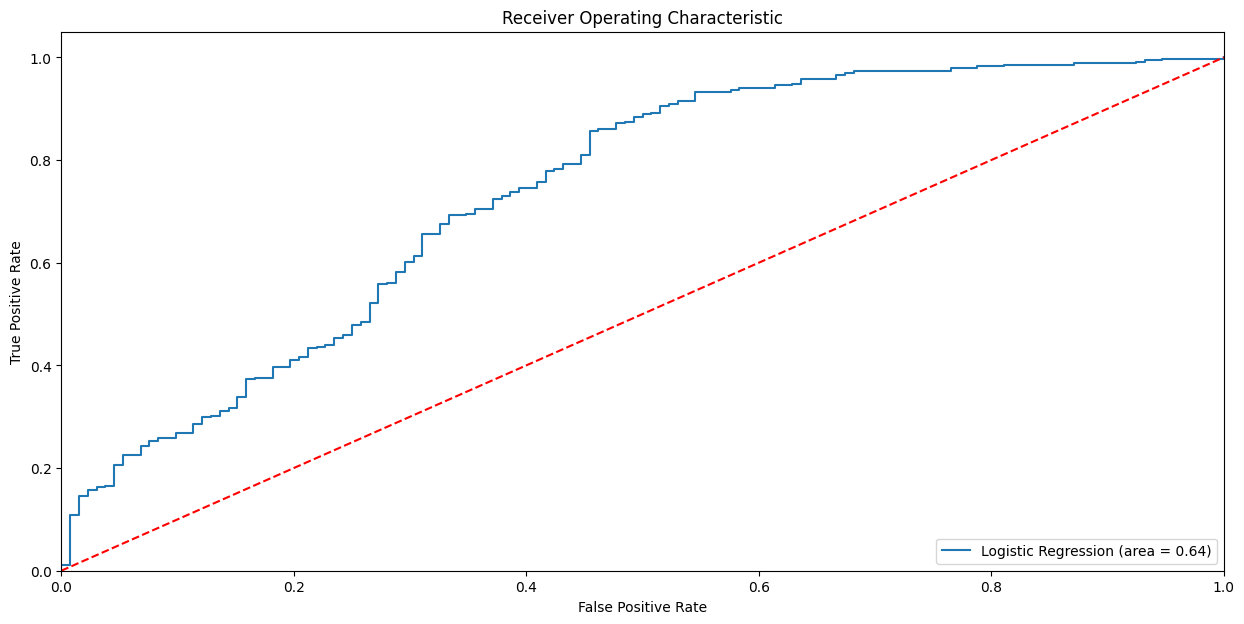

In [23]:
# ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])

# Define the figure
plt.figure(figsize=(15,7))

# Plot the ROC curve
plt.plot(false_positive_rate, true_positive_rate, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred))

# Plot the ROC curve of a purely random classifier 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Define the x and y labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add plot title
plt.title('Receiver Operating Characteristic')

# Define the legend
plt.legend(loc="lower right")
plt.show()

The dotted line represents the ROC curve of a purely random classifier.
A good classifier stays as far away from that line as possible to the left top corner.

## Conclusion
In this notebook, we explored logistic regression model to predict whether the short straddle strategy would generate positive returns after holding for 3 days or not. You can implement the same code on different options strategies to predict whether the strategy would be profitable or not over the holding period.